<a href="https://colab.research.google.com/github/yungdennek/258-Final-Project---Resume-Classification/blob/main/Siamese_Resume_Screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sarah Liang

In [ ]:
!pip install -U sentence-transformers datasets pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 143.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 144.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
 

In [ ]:
import pandas as pd
import numpy as np
import re
import random

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
)
from sklearn.linear_model import LogisticRegression

from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, util
from torch.utils.data import DataLoader
import torch

print("Torch device:", "cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Torch device: cuda


In [ ]:
raw_ds = load_dataset("AzharAli05/Resume-Screening-Dataset")
df = raw_ds["train"].to_pandas()

print("Columns:", df.columns)

print("\nDecision value counts:")
print(df["Decision"].value_counts(dropna=False))

# Drop missing text
df = df[df["Resume"].notna() & df["Job_Description"].notna()].copy()

# Map Decision -> label (minority class = positive)
vals = df["Decision"].value_counts()
classes = vals.index.tolist()

if len(classes) == 2:
    pos_class = vals.idxmin()   # minority
    neg_class = vals.idxmax()
    print(f"\nDetected 2 classes in Decision.")
    print(f"Treating {repr(pos_class)} as POSITIVE (1.0), {repr(neg_class)} as NEGATIVE (0.0).")

    def map_label(x):
        return 1.0 if x == pos_class else 0.0

else:
    print("\nMore than 2 unique Decision values; using simple heuristic mapping.")
    positive_keywords = ["select", "short", "suitable", "advance", "hire", "yes", "1"]

    def map_label(x):
        s = str(x).lower()
        return 1.0 if any(k in s for k in positive_keywords) else 0.0

df["label"] = df["Decision"].apply(map_label).astype(float)

print("\nLabel distribution after mapping:")
print(df["label"].value_counts())
assert df["label"].nunique() == 2, "Label mapping ended up with a single class. Check Decision values."


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

dataset.csv:   0%|          | 0.00/34.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10174 [00:00<?, ? examples/s]

Columns: Index(['Role', 'Resume', 'Decision', 'Reason_for_decision', 'Job_Description'], dtype='object')

Decision value counts:
Decision
reject    5114
select    5060
Name: count, dtype: int64

Detected 2 classes in Decision.
Treating 'select' as POSITIVE (1.0), 'reject' as NEGATIVE (0.0).

Label distribution after mapping:
label
0.0    5114
1.0    5060
Name: count, dtype: int64


In [ ]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b', "", text, flags=re.I)
    text = re.sub(r'[^a-z0-9\s]', ' ', text.lower())
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def clean_job_description(jd: str) -> str:
    if not isinstance(jd, str):
        return ""

    jd = jd.replace("\n", " ").strip()
    sentences = re.split(r'(?<=[.!?]) +', jd)

    cleaned_sentences = []

    feedback_patterns = [
        r"\bimpressive\b",
        r"\bstrong candidate\b",
        r"\bexceptional(ly)?\b",
        r"\bexcellent\b",
        r"\bperfect fit\b",
        r"\bperformed well\b",
        r"\bperformed exceptionally\b",
        r"\bshowed\b",
        r"\bdemonstrated\b",
        r"\boverall\b",
        r"\bhigh quality\b",
        r"\bprofessionalism\b",
        r"\bgreat enthusiasm\b",
        r"\bpositive attitude\b",
        r"\boutstanding\b",
        r"\bfeedback\b",
        r"\bhiring manager\b",
        r"\brecommend(ed)?\b",
        r"\bwas chosen\b",
        r"\bwas selected\b",
        r"\bthey were selected\b",
        r"\bgood experience\b",
        r"\bimpressed\b",
    ]

    requirement_keywords = [
        r"\bresponsibilit(y|ies)\b",
        r"\brequirement(s)?\b",
        r"\bmust\b",
        r"\bshould\b",
        r"\bexperience\b",
        r"\bknowledge\b",
        r"\bskills?\b",
        r"\bproficient\b",
        r"\beducation\b",
        r"\bbachelor\b",
        r"\bdegree\b",
        r"\bpreferred\b",
        r"\bminimum\b",
        r"\btools?\b",
        r"\btechnolog(y|ies)\b",
        r"\bqualifications?\b",
        r"\brole\b",
        r"\bduties\b"
    ]

    if len(sentences) == 1:
        sentences = [jd]

    for sentence in sentences:
        s = sentence.strip()
        if not s:
            continue

        s_lower = s.lower()

        if any(re.search(p, s_lower) for p in feedback_patterns):
            continue

        if any(re.search(p, s_lower) for p in requirement_keywords):
            cleaned_sentences.append(s)
            continue

        if re.search(
            r"\b(python|sql|java|c\+\+|c#|react|angular|node|docker|kubernetes|aws|gcp|azure|ml|machine learning|data|etl|api|design|ui|ux)\b",
            s_lower,
        ):
            cleaned_sentences.append(s)
            continue

    cleaned = " ".join(cleaned_sentences).strip()

    if len(cleaned) < 20:
        cleaned = clean_text(jd)

    return cleaned


In [ ]:
df["job_clean"] = df["Job_Description"].apply(clean_job_description)
df["resume_clean"] = df["Resume"].apply(clean_text)

df = df[(df["job_clean"].str.len() > 50) & (df["resume_clean"].str.len() > 50)].copy()
df = df.reset_index(drop=True)

print("\nAfter cleaning & length filtering:", len(df))
print("Label distribution:", df["label"].value_counts())



After cleaning & length filtering: 10173
Label distribution: label
0.0    5114
1.0    5059
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)
train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=42, stratify=train_df["label"]
)

print(f"Data Ready: {len(train_df)} Train, {len(val_df)} Val, {len(test_df)} Test\n")

print("Train label distribution:\n", train_df["label"].value_counts())
print("\nVal label distribution:\n", val_df["label"].value_counts())
print("\nTest label distribution:\n", test_df["label"].value_counts())


Data Ready: 7324 Train, 814 Val, 2035 Test

Train label distribution:
 label
0.0    3682
1.0    3642
Name: count, dtype: int64

Val label distribution:
 label
0.0    409
1.0    405
Name: count, dtype: int64

Test label distribution:
 label
0.0    1023
1.0    1012
Name: count, dtype: int64


In [ ]:
train_examples = [
    InputExample(
        texts=[row["job_clean"], row["resume_clean"]],
        label=float(row["label"])
    )
    for _, row in train_df.iterrows()
]

print(f"Created {len(train_examples)} training pairs.")

train_dataloader = DataLoader(
    train_examples,
    shuffle=True,
    batch_size=16   # 16 works well on Colab T4
)


Created 7324 training pairs.


In [ ]:
model_name = "all-MiniLM-L6-v2"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(model_name, device=device)
print("Base model loaded on", device, ":", model_name)

train_loss = losses.OnlineContrastiveLoss(
    model=model,
    distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE,
    margin=0.5
)

val_sent1 = val_df["job_clean"].tolist()
val_sent2 = val_df["resume_clean"].tolist()
val_labels = val_df["label"].tolist()

evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=val_sent1,
    sentences2=val_sent2,
    labels=val_labels,
    name="resume-screener-val"
)

print("Evaluator prepared with", len(val_labels), "validation pairs.")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Base model loaded on cuda : all-MiniLM-L6-v2
Evaluator prepared with 814 validation pairs.


In [ ]:
# api key 1490cda2042112518b2264a60e4953b7d746b0e4
num_epochs = 4
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
use_amp = True if device == "cuda" else False

print("Warmup steps:", warmup_steps)
print("use_amp:", use_amp)

print("Starting training...")

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path="fine_tuned_resume_model_minilm_online_cleanJD",
    save_best_model=True,
    show_progress_bar=True,
    use_amp=use_amp
)

print("Training complete. Best model saved to 'fine_tuned_resume_model_minilm_online_cleanJD'.")


Warmup steps: 183
use_amp: False
Starting training...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

In [ ]:
fine_tuned_model = SentenceTransformer("fine_tuned_resume_model_minilm_online_cleanJD")

print("Generating Test Embeddings...")
test_jd_vecs = fine_tuned_model.encode(
    test_df["job_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)
test_res_vecs = fine_tuned_model.encode(
    test_df["resume_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

test_scores = np.array([
    cosine_similarity([j], [r])[0][0]
    for j, r in zip(test_jd_vecs, test_res_vecs)
])
y_test = test_df["label"].values

test_auc = roc_auc_score(y_test, test_scores)
test_pr_auc = average_precision_score(y_test, test_scores)

def precision_at_k(y_true, y_scores, k=10):
    idx = np.argsort(y_scores)[::-1][:k]
    return y_true[idx].mean()

p_at_10 = precision_at_k(y_test, test_scores, k=10)
p_at_50 = precision_at_k(y_test, test_scores, k=50)

print("\n--- DEEP LEARNING (MiniLM + OnlineContrastiveLoss, CLEAN JD) RESULTS ---")
print(f"Test ROC-AUC: {test_auc:.4f}")
print(f"Test PR-AUC:  {test_pr_auc:.4f}")
print(f"Test P@10:    {p_at_10:.2f}")
print(f"Test P@50:    {p_at_50:.2f}")


Generating Test Embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]


--- DEEP LEARNING (MiniLM + OnlineContrastiveLoss, CLEAN JD) RESULTS ---
Test ROC-AUC: 0.6558
Test PR-AUC:  0.6819
Test P@10:    1.00
Test P@50:    1.00


In [ ]:
print("Encoding validation pairs for calibration...")
val_jd_vecs = fine_tuned_model.encode(
    val_df["job_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)
val_res_vecs = fine_tuned_model.encode(
    val_df["resume_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

val_scores = np.array([
    cosine_similarity([j], [r])[0][0]
    for j, r in zip(val_jd_vecs, val_res_vecs)
])
val_labels = val_df["label"].values

print("Validation scores shape:", val_scores.shape)
print("Validation labels distribution:", np.unique(val_labels, return_counts=True))

X_val = val_scores.reshape(-1, 1)
y_val = val_labels

calib_clf = LogisticRegression(max_iter=1000)
calib_clf.fit(X_val, y_val)

print("Calibration model trained.")

val_prob = calib_clf.predict_proba(X_val)[:, 1]
print("Validation ROC-AUC (calibrated prob):", roc_auc_score(y_val, val_prob))
print("Validation Brier score:", brier_score_loss(y_val, val_prob))

test_prob = calib_clf.predict_proba(test_scores.reshape(-1, 1))[:, 1]
print("Calibrated Test ROC-AUC:", roc_auc_score(y_test, test_prob))
print("Calibrated Test Brier score:", brier_score_loss(y_test, test_prob))


Encoding validation pairs for calibration...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Validation scores shape: (814,)
Validation labels distribution: (array([0., 1.]), array([409, 405]))
Calibration model trained.
Validation ROC-AUC (calibrated prob): 0.5943131395454134
Validation Brier score: 0.24245738666642128
Calibrated Test ROC-AUC: 0.6557724703364127
Calibrated Test Brier score: 0.24060748586307842


In [ ]:
def score_resume_prob(job_desc: str, resume_txt: str) -> float:
    """
    Given a job description and a resume, return P(pass | job, resume)
    using:
      - fine-tuned MiniLM Siamese model (cleaned JD)
      - cosine similarity
      - logistic regression calibration
    """
    j_c = clean_job_description(job_desc)
    r_c = clean_text(resume_txt)

    emb = fine_tuned_model.encode([j_c, r_c])
    sim = cosine_similarity([emb[0]], [emb[1]])[0][0]

    prob_pass = calib_clf.predict_proba([[sim]])[0, 1]
    return float(prob_pass)

# Quick sanity check
job = "Data Scientist role requiring Python, SQL, machine learning, and statistics."
good_res = """
Data Scientist with 3 years of experience.
Strong in Python (pandas, scikit-learn), SQL, regression, classification, and A/B testing.
Built machine learning models for churn prediction and recommendation systems.
"""

bad_res = """
Senior Chef with 10 years of experience leading kitchen staff.
Expert in Italian cuisine, menu design, inventory, and staff scheduling.
"""

print("Good resume probability:", f"{score_resume_prob(job, good_res):.3f}")
print("Bad  resume probability:", f"{score_resume_prob(job, bad_res):.3f}")


Good resume probability: 0.604
Bad  resume probability: 0.476


In [ ]:
def score_resume_dl(job_desc: str, resume_txt: str) -> float:
    j_c = clean_job_description(job_desc)
    r_c = clean_text(resume_txt)
    embeddings = fine_tuned_model.encode([j_c, r_c])
    score = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return float(score)

job_text = "Senior Software Engineer. Requires Python, AWS, and System Design experience."

bad_resume = """
fresh graduate with no experience.
skills: microsoft word, typing.
"""

hacked_resume = """
as a seasoned fresh graduate with no experience.
skills: microsoft word, typing.
"""

print("Scoring Bad Resume...")
score_bad = score_resume_dl(job_text, bad_resume)

print("Scoring Hacked Resume...")
score_hacked = score_resume_dl(job_text, hacked_resume)

print("\n" + "="*30)
print(f"Original Score: {score_bad:.4f}")
print(f"Hacked Score:   {score_hacked:.4f}")
print(f"Difference:     {score_hacked - score_bad:.4f}")
print("="*30)

if (score_hacked - score_bad) > 0.05:
    print("WARNING: The word 'seasoned' still gives a massive boost.")
else:
    print("SUCCESS: The 'seasoned' leak appears fixed or negligible.")


Scoring Bad Resume...
Scoring Hacked Resume...

Original Score: 0.6568
Hacked Score:   0.6910
Difference:     0.0342
SUCCESS: The 'seasoned' leak appears fixed or negligible.


Generating embeddings for the test set...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Running t-SNE (2D)...


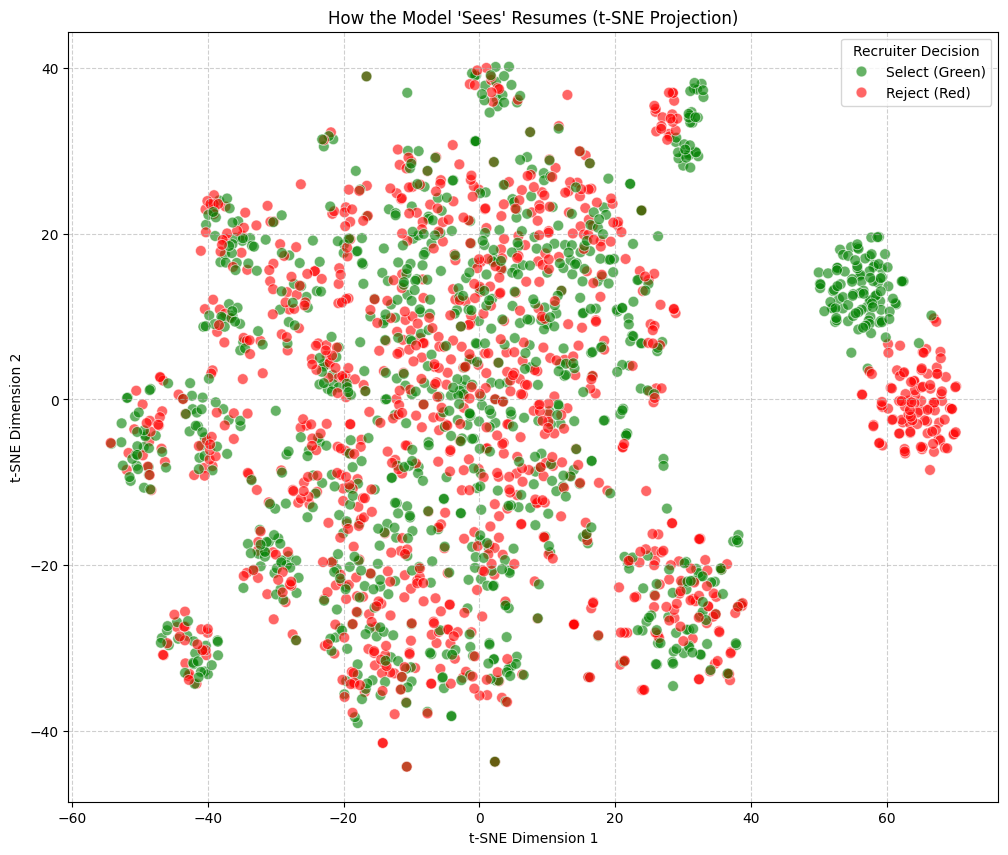

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

print("Generating embeddings for the test set...")
test_resume_embeddings = fine_tuned_model.encode(
    test_df["resume_clean"].tolist(),
    batch_size=64,
    show_progress_bar=True
)

print("Running t-SNE (2D)...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
embeddings_2d = tsne.fit_transform(test_resume_embeddings)

label_map = {1.0: 'Select (Green)', 0.0: 'Reject (Red)'}
viz_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'Label': test_df["label"].map(label_map)
})

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=viz_df,
    x='x',
    y='y',
    hue='Label',
    palette={'Select (Green)': 'green', 'Reject (Red)': 'red'},
    alpha=0.6,
    s=60
)

plt.title("How the Model 'Sees' Resumes (t-SNE Projection)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Recruiter Decision")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Generating scores for graphs...


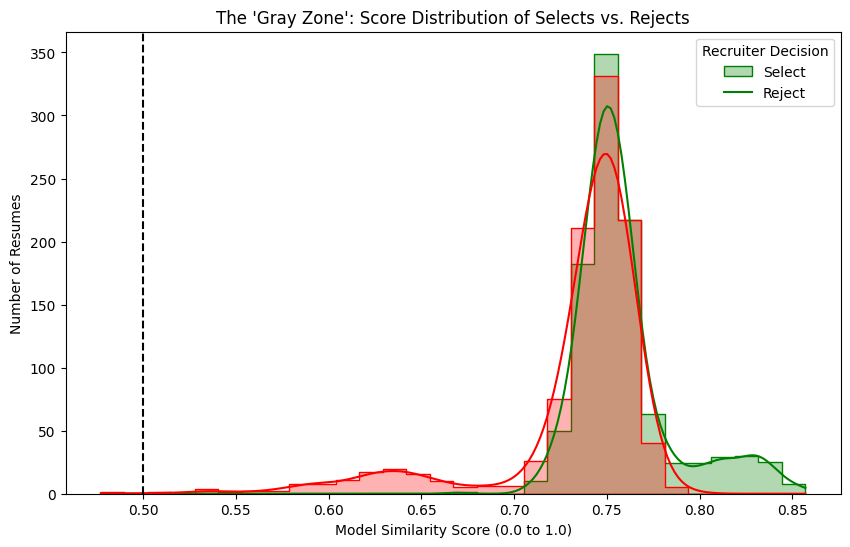

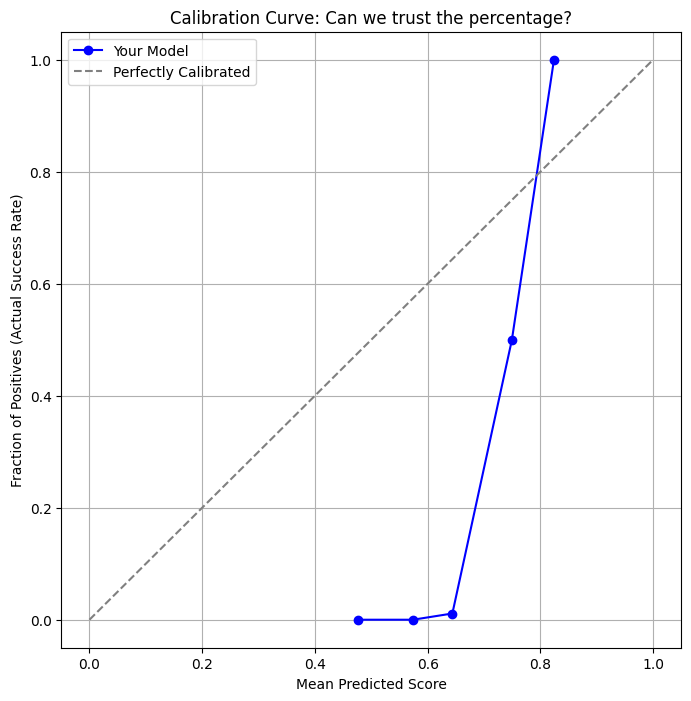

In [ ]:
from sentence_transformers import util
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

print("Generating scores for graphs...")
test_embeddings_resume = fine_tuned_model.encode(test_df["resume_clean"].tolist())
test_embeddings_job = fine_tuned_model.encode(test_df["job_clean"].tolist())

# Calculate Cosine Similarity scores
scores = [util.cos_sim(j, r)[0][0].item() for j, r in zip(test_embeddings_job, test_embeddings_resume)]
test_df["predicted_score"] = scores

plt.figure(figsize=(10, 6))
sns.histplot(
    data=test_df,
    x="predicted_score",
    hue="label",
    bins=30,
    kde=True, # Adds the smooth curve line
    palette={1.0: 'green', 0.0: 'red'},
    element="step",
    alpha=0.3
)
plt.title("The 'Gray Zone': Score Distribution of Selects vs. Rejects")
plt.xlabel("Model Similarity Score (0.0 to 1.0)")
plt.ylabel("Number of Resumes")
plt.axvline(x=0.5, color='black', linestyle='--', label="Default Threshold (0.5)")
plt.legend(title="Recruiter Decision", labels=["Select", "Reject"])
plt.show()

# bin the scores into buckets (e.g., 0-10%, 10-20%...)
prob_true, prob_pred = calibration_curve(test_df["label"], test_df["predicted_score"], n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Your Model', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
plt.title("Calibration Curve: Can we trust the percentage?")
plt.xlabel("Mean Predicted Score")
plt.ylabel("Fraction of Positives (Actual Success Rate)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

def traffic_light(prob: float) -> str:
    """
    Simple visual banding:
      > 0.70 -> Green (strong)
      0.40–0.70 -> Yellow (maybe)
      < 0.40 -> Red (unlikely)
    """
    if prob >= 0.70:
        return "GREEN (strong)"
    elif prob >= 0.40:
        return "YELLOW (maybe)"
    else:
        return "RED (unlikely)"


def should_advance(job_desc: str, resume_txt: str, threshold: float = 0.6):
    """
    Returns:
      - prob: calibrated probability of passing
      - decision: True if prob >= threshold, else False
      - band: 'GREEN / YELLOW / RED'
    """
    prob = score_resume_prob(job_desc, resume_txt)
    band = traffic_light(prob)
    return prob, prob >= threshold, band


def rank_resumes_for_job(job_desc: str, resumes: list[str], top_k: int = 10):
    """
    Given a job description and a list of resume texts, returns a list of
    (probability, band, resume_text) sorted from best to worst.
    """
    scores = []
    for r in resumes:
        prob = score_resume_prob(job_desc, r)
        band = traffic_light(prob)
        scores.append((prob, band, r))

    scores_sorted = sorted(scores, key=lambda x: x[0], reverse=True)
    return scores_sorted[:top_k]


# small demo
demo_job = "Backend engineer role requiring Python, SQL, and AWS experience."

demo_resumes = [
    "CS graduate with experience in Python and SQL. Built APIs with Flask and deployed on AWS.",
    "Graphic designer with 3 years of experience in Figma, Photoshop, and Illustrator.",
    "Data engineer with strong Python, ETL pipelines, Airflow, and AWS Redshift.",
]

ranked = rank_resumes_for_job(demo_job, demo_resumes, top_k=3)

for i, (prob, band, text) in enumerate(ranked, start=1):
    print(f"\nRank {i}:")
    print(f"  Prob(pass): {prob:.3f}  ->  {band}")
    print("  Snippet:", text[:120].replace("\n", " "), "...")



Rank 1:
  Prob(pass): 0.536  ->  YELLOW (maybe)
  Snippet: CS graduate with experience in Python and SQL. Built APIs with Flask and deployed on AWS. ...

Rank 2:
  Prob(pass): 0.522  ->  YELLOW (maybe)
  Snippet: Data engineer with strong Python, ETL pipelines, Airflow, and AWS Redshift. ...

Rank 3:
  Prob(pass): 0.443  ->  YELLOW (maybe)
  Snippet: Graphic designer with 3 years of experience in Figma, Photoshop, and Illustrator. ...


In [ ]:

resume = """
Software engineer.
Python, SQL, ML, deployed models on AWS.
Built REST APIs, worked with Docker and CI/CD pipelines.
"""

data_sci_job = "Looking for a Data Scientist with strong Python, SQL, and machine learning background."
frontend_job = "Looking for a Frontend Engineer with React, CSS, and UI/UX design experience."

prob_ds = score_resume_prob(data_sci_job, resume)
prob_fe = score_resume_prob(frontend_job, resume)

print("Same resume, different jobs:\n")
print("Data Scientist job  -> Prob(pass):", f"{prob_ds:.3f}", "->", traffic_light(prob_ds))
print("Frontend job        -> Prob(pass):", f"{prob_fe:.3f}", "->", traffic_light(prob_fe))


Same resume, different jobs:

Data Scientist job  -> Prob(pass): 0.459 -> YELLOW (maybe)
Frontend job        -> Prob(pass): 0.375 -> RED (unlikely)


In [ ]:

job_fair = "Software engineer role requiring Python, Git, and system design experience."

base_resume = """
Software engineer with 3 years of experience.
Python, Git, system design, microservices.
Worked on scalable backend services and REST APIs.
"""

# Name variations
resume_john = "John Doe\n" + base_resume
resume_aisha = "Aisha Khan\n" + base_resume
resume_wei = "Wei Zhang\n" + base_resume

print("=== Name-only variation (same content) ===")
for name, res in [("John", resume_john), ("Aisha", resume_aisha), ("Wei", resume_wei)]:
    prob = score_resume_prob(job_fair, res)
    print(f"{name} prob(pass): {prob:.3f} -> {traffic_light(prob)}")


# gender-coded clubs / cues
resume_stem_neutral = base_resume + "\nMember of STEM club at university."
resume_stem_women   = base_resume + "\nLeader of Women in STEM club at university."

print("\n=== Club wording variation ===")
print("STEM club prob(pass):         ", f"{score_resume_prob(job_fair, resume_stem_neutral):.3f}")
print("Women in STEM club prob(pass):", f"{score_resume_prob(job_fair, resume_stem_women):.3f}")


# Pronoun cues
resume_she = "She/her.\n" + base_resume
resume_he  = "He/him.\n" + base_resume

print("\n=== Pronoun cue variation ===")
print("She/her prob(pass):", f"{score_resume_prob(job_fair, resume_she):.3f}")
print("He/him prob(pass): ", f"{score_resume_prob(job_fair, resume_he):.3f}")


=== Name-only variation (same content) ===
John prob(pass): 0.593 -> YELLOW (maybe)
Aisha prob(pass): 0.587 -> YELLOW (maybe)
Wei prob(pass): 0.583 -> YELLOW (maybe)

=== Club wording variation ===
STEM club prob(pass):          0.597
Women in STEM club prob(pass): 0.599

=== Pronoun cue variation ===
She/her prob(pass): 0.575
He/him prob(pass):  0.614


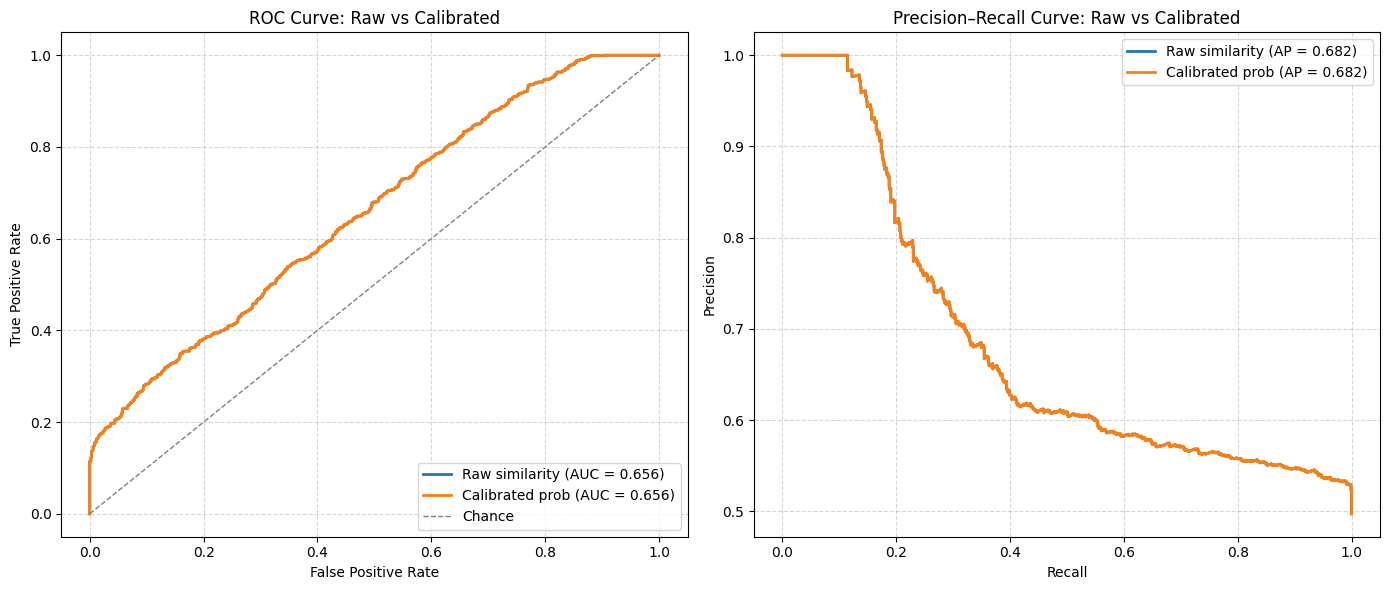

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

y_true = y_test
sim_scores = test_scores        # raw cosine similarity
calib_scores = test_prob        # calibrated probability from LogisticRegression

# ---------- 1. ROC data ----------
fpr_sim, tpr_sim, _ = roc_curve(y_true, sim_scores)
roc_auc_sim = auc(fpr_sim, tpr_sim)

fpr_cal, tpr_cal, _ = roc_curve(y_true, calib_scores)
roc_auc_cal = auc(fpr_cal, tpr_cal)

# ---------- 2. PR data ----------
prec_sim, rec_sim, _ = precision_recall_curve(y_true, sim_scores)
ap_sim = average_precision_score(y_true, sim_scores)

prec_cal, rec_cal, _ = precision_recall_curve(y_true, calib_scores)
ap_cal = average_precision_score(y_true, calib_scores)

# ---------- 3. Plot ----------
plt.figure(figsize=(14, 6))

# --- Left: ROC ---
plt.subplot(1, 2, 1)
plt.plot(fpr_sim, tpr_sim, label=f"Raw similarity (AUC = {roc_auc_sim:.3f})", linewidth=2)
plt.plot(fpr_cal, tpr_cal, label=f"Calibrated prob (AUC = {roc_auc_cal:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Raw vs Calibrated")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)

# --- Right: Precision–Recall ---
plt.subplot(1, 2, 2)
plt.plot(rec_sim, prec_sim, label=f"Raw similarity (AP = {ap_sim:.3f})", linewidth=2)
plt.plot(rec_cal, prec_cal, label=f"Calibrated prob (AP = {ap_cal:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve: Raw vs Calibrated")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
